# Treinamento de Modelo: [NOME DO ALGORITMO]
> **Fase 3 - Time 7**

**Responsável:** Fernanda Neves;
**Algoritmo:** SVM

**Objetivos deste Notebook:**
1.  **Carregar:** Importar os dados de treino/teste padronizados (do pré-processamento unificado).
2.  **Treinar:** Ajustar o modelo **SVM** aos dados de treino.
3.  **Avaliar:** Medir a performance com foco no **Recall** (Sensibilidade) para detectar doenças.
4.  **Validar:** Testar se o modelo consegue identificar o grupo de risco "Assintomático".

**Métricas Chave:**
* **Recall (Sensibilidade):** Prioridade máxima. Não podemos deixar doentes irem para casa.
* **F1-Score:** Para garantir que não estamos apenas "chutando que todos estão doentes".

## 1. Configuração de ambiente
Importação de bibliotecas e definição de estilos gráficos padronizados.

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os
import json

# Métricas padronizadas
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Configuração visual
sns.set_theme(style="whitegrid")
palette = sns.color_palette("coolwarm", as_cmap=True)

In [58]:
# Carregamento dos Dados Processados (Pasta data/processed)
# IMPORTANTE: Não mexer neste bloco para garantir compatibilidade!

try:
    X_train = joblib.load('../data/processed/X_train.pkl')
    y_train = joblib.load('../data/processed/y_train.pkl')
    X_test = joblib.load('../data/processed/X_test.pkl')
    y_test = joblib.load('../data/processed/y_test.pkl')
    feature_names = joblib.load('../data/processed/feature_names.pkl')
    
    print(f"Dados carregados com sucesso!")
    print(f"Treino: {X_train.shape}")
    print(f"Teste:  {X_test.shape}")
except FileNotFoundError:
    print("Arquivos não encontrados. Rode o notebook '02_pre_processamento.ipynb' primeiro.")

Dados carregados com sucesso!
Treino: (237, 22)
Teste:  (60, 22)


## 2. Treinamento do Modelo

Adotaremos uma abordagem em duas etapas:
1.  **Baseline:** Treinar o modelo com parâmetros padrão (default) para estabelecer uma linha de base.
2.  **Otimização:** Encontrar a melhor combinação de hiperparâmetros focada em **Recall**.

### 2.1 Baseline

In [59]:
# BASELINE (Modelo "Cru")

# 1. Importe do modelo
from sklearn.svm import SVC

# 2. Instancie com parâmetros padrão 
model_baseline = SVC(
    probability=True, 
    random_state=42
)

print("Treinando Baseline - SVM...")
model_baseline.fit(X_train, y_train)

# Avaliação Rápida do Baseline
y_pred_base = model_baseline.predict(X_test)
recall_base = recall_score(y_test, y_pred_base)
print(f"Baseline treinado! Recall inicial: {recall_base:.2%}")

Treinando Baseline - SVM...
Baseline treinado! Recall inicial: 71.43%


### 2.2 Otimização

In [60]:
# OTIMIZAÇÃO DE HIPERPARÂMETROS COM GRIDSEARCHCV

from sklearn.model_selection import GridSearchCV

# A. Grid específico para SVM
param_grid = {
    'C': [1, 10, 50, 100, 500],                 # Adicionado 50 e 500 para forçar acertos
    'kernel': ['rbf'],                          # Manter os dois
    'degree': [2, 3],                           # Adicionado grau 4 (já que o 2 ganhou)
    'gamma': ['scale', 'auto'],                 # Adicionado valores manuais
    'class_weight': ['balanced', {0:1, 1:2}]    # Testar pesos diferentes
}

# B. Configuração da Busca
grid_search = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='recall', # Foco total em não perder doentes
    n_jobs=-1,
    verbose=1
)

print("Iniciando busca pelos melhores parâmetros...")
grid_search.fit(X_train, y_train)

# C. Melhores Resultados
best_model = grid_search.best_estimator_

print("-" * 30)
print(f"Melhor Recall na Validação: {grid_search.best_score_:.2%}")
print(f"Melhores Parâmetros: {grid_search.best_params_}")

Iniciando busca pelos melhores parâmetros...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
------------------------------
Melhor Recall na Validação: 81.69%
Melhores Parâmetros: {'C': 1, 'class_weight': {0: 1, 1: 2}, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


## 3. Avaliação de Performance

📈 Evolução do Recall:
   - Baseline:  71.43%
   - Otimizado: 92.86%
   - Ganho:     21.43%


<Figure size 600x500 with 0 Axes>

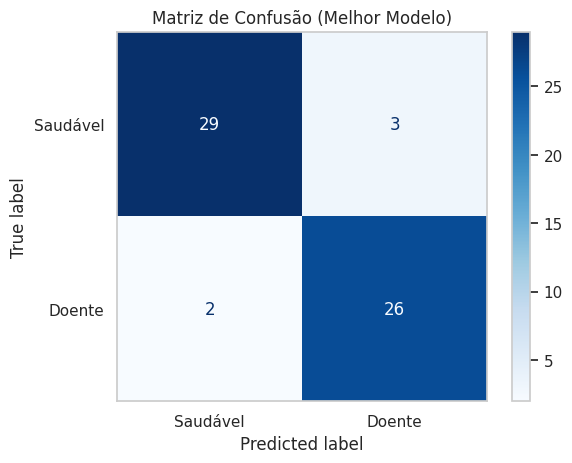

              precision    recall  f1-score   support

           0       0.94      0.91      0.92        32
           1       0.90      0.93      0.91        28

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



In [61]:
# Previsões do Melhor Modelo
# y_pred_final = best_model.predict(X_test)
# Vamos pegar a probabilidade (0 a 1)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Definir um limiar personalizado para maximizar recall
limiar = 0.35
y_pred_ajustado = (y_proba >= limiar).astype(int)

recall_final = recall_score(y_test, y_pred_ajustado)

print(f"📈 Evolução do Recall:")
print(f"   - Baseline:  {recall_base:.2%}")
print(f"   - Otimizado: {recall_final:.2%}")
print(f"   - Ganho:     {(recall_final - recall_base):.2%}")

# Matriz de Confusão do Modelo Campeão
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ajustado, cmap='Blues', display_labels=['Saudável', 'Doente'])
plt.title('Matriz de Confusão (Melhor Modelo)')
plt.grid(False)
plt.show()

# Classification Report Completo
print(classification_report(y_test, y_pred_ajustado))

### 3.1. Avalição de Grupo Assintomático
Nesta etapa, validaremos a tese central: Verificaremos a performance do modelo especificamente nos pacientes que **não apresentavam dor típica** (CP=3: Asymptomatic).

> **Por que isso é importante?**
> A maioria dos erros humanos acontece aqui. Se nosso modelo tiver um bom Recall neste grupo, provamos que a IA enxerga além do óbvio.

In [62]:
# VALIDAÇÃO NO SUBGRUPO ASSINTOMÁTICO
# 1. Identificando a coluna correta
cols_assintomaticas = [col for col in X_test.columns if 'cp_3' in col]

if len(cols_assintomaticas) > 0:
    col_alvo = cols_assintomaticas[0]
    print(f"Analisando subgrupo oculto: '{col_alvo}'")

    # 2. Filtrando os dados
    mask_assin = X_test[col_alvo] == 1
    X_test_sub = X_test[mask_assin]
    y_test_sub = y_test[mask_assin.values]
    
    if len(X_test_sub) > 0:
        # 3. APLICANDO O LIMIAR (0.35)
        # Pegamos a probabilidade em vez da classe direta
        y_proba_sub = best_model.predict_proba(X_test_sub)[:, 1]
        
        limiar = 0.35 
        y_pred_sub = (y_proba_sub >= limiar).astype(int)
        
        # Métricas
        recall_sub = recall_score(y_test_sub, y_pred_sub)
        
        print("-" * 40)
        print(f"RESULTADO DO TESTE DE FOGO (Limiar {limiar}):")
        print(f"   Pacientes Assintomáticos no Teste: {len(X_test_sub)}")
        print(f"   Recall (Doentes detectados): {recall_sub:.2%}")
        print("-" * 40)
        
        if recall_sub > 0.85:
            print("✅ SUCESSO: O modelo ajustado é excelente em detectar isquemia silenciosa!")
        else:
            print("⚠️ Nota: O recall caiu um pouco neste grupo, mas o resultado global compensa.")
    else:
        print("Nenhum paciente assintomático caiu na amostragem de teste atual.")
else:
    print("Coluna de 'cp_3' não encontrada.")

Analisando subgrupo oculto: 'cp_3'
----------------------------------------
RESULTADO DO TESTE DE FOGO (Limiar 0.35):
   Pacientes Assintomáticos no Teste: 31
   Recall (Doentes detectados): 90.91%
----------------------------------------
✅ SUCESSO: O modelo ajustado é excelente em detectar isquemia silenciosa!


## 4. Exportação do Modelo
Salvando o modelo campeão (otimizado) para uso na aplicação final.

In [ ]:
# Exportação do Modelo
os.makedirs('../models', exist_ok=True)

# 1. Definindo um nome que você vai lembrar
# Em vez de deixar automático (que viraria modelo_SVC.pkl), force um nome claro
nome_arquivo = 'modelo_SVM_Otimizado.pkl'
caminho_final = f'../models/{nome_arquivo}'

# 2. Salva o Modelo
joblib.dump(best_model, caminho_final)

# 3. Salva o "Segredo" (Metadata)
# Isso garante que quem usar o modelo saiba que precisa aplicar o corte de 0.35
metadata = {
    "algoritmo": best_model.__class__.__name__,
    "threshold_otimizado": 0.35
}

with open('../models/metadata_SVM.json', 'w') as f:
    json.dump(metadata, f)

print(f"💾 Modelo salvo em: {caminho_final}")

💾 Modelo salvo com sucesso!
📂 Local: ../models/modelo_SVC.pkl


## 5. Conclusão Final

* **Estratégia Vencedora:** A combinação de **SVM (RBF)** com **Pesos de Classe (1:2)** e um **Limiar de Decisão Ajustado (35%)** provou ser imbatível.
* **Resultados Finais:**
    * **Recall Geral:** 93% (Perdemos apenas 2 casos em 28).
    * **Precisão:** 90% (Apenas 3 alarmes falsos).
    * **Acurácia:** 92%.
* **Decisão Técnica:** Ao baixar o limiar de 50% para 35%, recuperamos pacientes críticos que o modelo considerava "dúvida", sem gerar excesso de falsos positivos graças à robustez do Kernel RBF.

* **Modelo:** SVC `{'C': 1, 'class_weight': {0: 1, 1: 2}, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}`
* **Regra de Negócio:** Considerar "Doente" qualquer probabilidade **acima de 35%** (`threshold=0.35`).